In [10]:
import pandas as pd
import os

# Set working directory
os.chdir(os.path.expanduser('~/Desktop/media-bias-annotator'))
print(os.getcwd())

# Load the dataset
labeled_df = pd.read_csv('data/new_labeled_dataset.csv')

# Preview
print(labeled_df.head())
print(labeled_df.columns)  # See available columns

/Users/yunlin/Dropbox/My Mac (Yunlin’s MacBook Pro)/Desktop/media-bias-annotator
                                            sentence  \
0  YouTube is making clear there will be no “birt...   
1  The increasingly bitter dispute between Americ...   
2  So while there may be a humanitarian crisis dr...   
3  A professor who teaches climate change classes...   
4  Looking around the United States, there is nev...   

                                           news_link      outlet  \
0  https://eu.usatoday.com/story/tech/2020/02/03/...   usa-today   
1  https://www.nbcnews.com/news/sports/women-s-te...       msnbc   
2  https://www.alternet.org/2019/01/here-are-5-of...    alternet   
3  https://www.breitbart.com/politics/2019/05/09/...   breitbart   
4  https://thefederalist.com/2020/03/11/woman-who...  federalist   

            topic    type  group_id  num_sent  Label_bias  \
0  elections-2020  center         1         1      Biased   
1           sport    left         1         1  Non-

In [11]:
# Text Libraries
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [12]:
# Machine Learning Libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [13]:
# Make a copy of the original dataset
df = labeled_df.copy()

## Recode label_bias variable
# Drop rows where label_bias is 'no-agreement'
df = df[df['Label_bias'].isin(['Biased', 'Non-biased'])]

# Map to binary
df['Label_bias_binary'] = df['Label_bias'].map({'Biased': 1, 'Non-biased': 0})

print(df['Label_bias_binary'].value_counts())

Label_bias_binary
1    1018
0     533
Name: count, dtype: int64


In [14]:
## Create a new variable: n_biased_words
# Turn strings into lists
import ast
if isinstance(df['biased_words4'].iloc[0], str):
    df['biased_words4'] = df['biased_words4'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Remove stopwords
stopword = stopwords.words('english')
df['biased_words'] = df['biased_words4'].apply(lambda wordlist: [w for w in wordlist if w.lower() not in stopword])

# Calculate the # of biased words for each sentence
df['n_biased_words'] = df['biased_words'].apply(len)

In [15]:
## Text cleaning & preprocessing
# regular expression to identify non-ascii characters
non_ascii_regex = r'[^\x00-\x7F]+'

def tokenize(text):
    text = re.sub(non_ascii_regex, ' ', text)    # Remove non-ASCII
    text = text.lower()                          # Lowercase for consistency
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  # Remove punctuation
    tokens = text.split()                        # Split on whitespace
    clean_tokens = [w for w in tokens if w not in stopword]
    return clean_tokens

# Test using an example sentence
sample = "Hello! This is a test sentence: Let's see how it handles punctuation, emojis 😊, and stopwords."
print(tokenize(sample))

['hello', 'test', 'sentence', 'let', 'see', 'handles', 'punctuation', 'emojis', 'stopwords']


In [16]:
## Create new text statistics columns
# Calculate number of words in each sentence
df['sentence_word_count'] = df['sentence'].apply(lambda x: len(tokenize(x)))

# Calculate average word length in each sentence
def avg_word_length(tokens):
    if len(tokens) == 0:
        return 0
    return np.mean([len(w) for w in tokens])

df['avg_word_length'] = df['sentence'].apply(lambda x: avg_word_length(tokenize(x)))

# Unique word count
df['unique_word_count'] = df['sentence'].apply(lambda x: len(set(tokenize(x))))

In [17]:
print(df.columns)

Index(['sentence', 'news_link', 'outlet', 'topic', 'type', 'group_id',
       'num_sent', 'Label_bias', 'Label_opinion', 'article', 'biased_words4',
       'merge_domain', 'factual_reporting', 'reliability_label',
       'Label_bias_binary', 'biased_words', 'n_biased_words',
       'sentence_word_count', 'avg_word_length', 'unique_word_count'],
      dtype='object')


In [18]:
## Select text features only
features = ['sentence', 'num_sent', 'n_biased_words', 'sentence_word_count', 'avg_word_length', 'unique_word_count']
target = 'Label_bias_binary'

X = df[features]
y = df[target]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify keeps class balance!
)

In [19]:
text_col = 'sentence'
num_cols = ['num_sent', 'n_biased_words', 'sentence_word_count', 'avg_word_length', 'unique_word_count']

text_transformer = TfidfVectorizer(
    tokenizer=tokenize, preprocessor=None, token_pattern=None,
    ngram_range=(1,2), max_features=1000
)

num_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_col),
        ('num', num_transformer, num_cols)
    ]
)

In [20]:
# import packages for model training
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

In [21]:
## Classifier pipelines
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=5)) 
    ]),
    'SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LinearSVC(class_weight='balanced', max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(eval_metric='logloss', random_state=42,
                                    scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1)))
    ]),
}


In [22]:
## Cross-validation comparison
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics = ['f1', 'accuracy', 'roc_auc']
results = {m: {} for m in metrics}

for name, model in models.items():
    for metric in metrics:
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=metric)
        results[metric][name] = scores
        print(f"{name} - {metric}: {scores.mean():.3f} ± {scores.std():.3f}")


Logistic Regression - f1: 0.832 ± 0.010
Logistic Regression - accuracy: 0.793 ± 0.010
Logistic Regression - roc_auc: 0.887 ± 0.011
KNN - f1: 0.840 ± 0.012
KNN - accuracy: 0.784 ± 0.017
KNN - roc_auc: 0.835 ± 0.004
SVM - f1: 0.836 ± 0.017
SVM - accuracy: 0.788 ± 0.018
SVM - roc_auc: 0.868 ± 0.008
Random Forest - f1: 0.857 ± 0.004
Random Forest - accuracy: 0.806 ± 0.007
Random Forest - roc_auc: 0.872 ± 0.011
XGBoost - f1: 0.845 ± 0.019
XGBoost - accuracy: 0.796 ± 0.026
XGBoost - roc_auc: 0.869 ± 0.010


/var/folders/rm/6mtj7p8d2fz8qhs9gm648gm80000gn/T/ipykernel_42601/40768084.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results[metric].values(), labels=results[metric].keys())


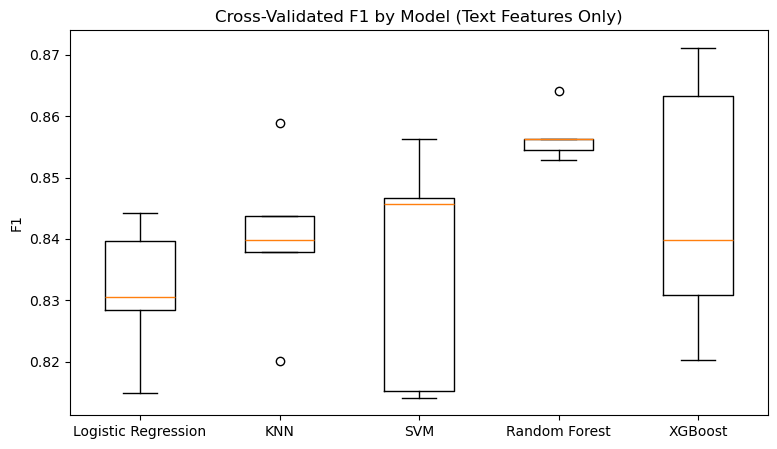

/var/folders/rm/6mtj7p8d2fz8qhs9gm648gm80000gn/T/ipykernel_42601/40768084.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results[metric].values(), labels=results[metric].keys())


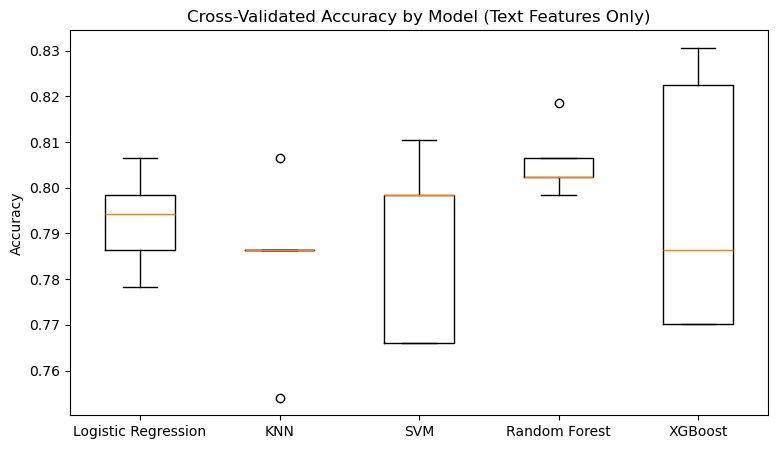

/var/folders/rm/6mtj7p8d2fz8qhs9gm648gm80000gn/T/ipykernel_42601/40768084.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results[metric].values(), labels=results[metric].keys())


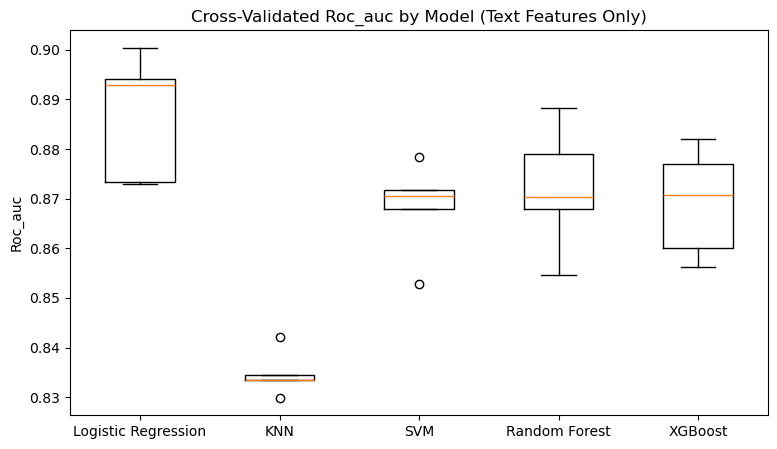

In [23]:
# Boxplot for each metric
for metric in metrics:
    plt.figure(figsize=(9,5))
    plt.boxplot(results[metric].values(), labels=results[metric].keys())
    plt.ylabel(metric.capitalize())
    plt.title(f'Cross-Validated {metric.capitalize()} by Model (Text Features Only)')
    plt.show()


In [24]:
## Fit the logistic regression & random forest models
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.66      0.83      0.74       107
           1       0.90      0.78      0.83       204

    accuracy                           0.80       311
   macro avg       0.78      0.81      0.79       311
weighted avg       0.82      0.80      0.80       311



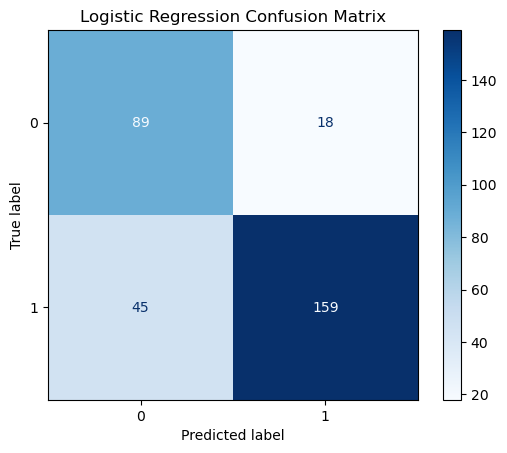

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.69      0.66      0.68       107
           1       0.83      0.84      0.83       204

    accuracy                           0.78       311
   macro avg       0.76      0.75      0.76       311
weighted avg       0.78      0.78      0.78       311



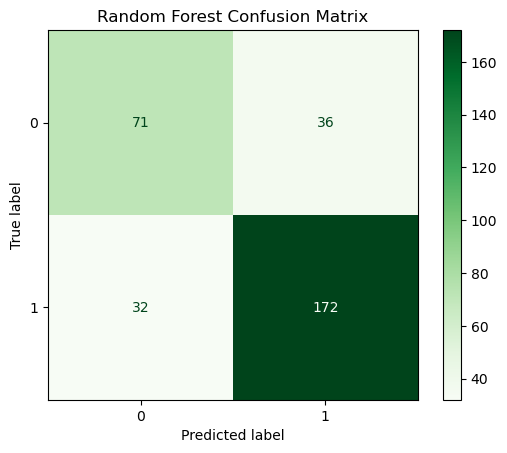

In [25]:
## Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Logistic Regression
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log))
cm_log = confusion_matrix(y_test, y_pred_log)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=log_reg.named_steps['classifier'].classes_)
disp_log.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Random Forest
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.named_steps['classifier'].classes_)
disp_rf.plot(cmap='Greens')
plt.title('Random Forest Confusion Matrix')
plt.show()


In [26]:
## Feature Importance for Random Forest
# Get all feature names
text_features = preprocessor.named_transformers_['text'].get_feature_names_out()
num_features = num_cols
all_features = np.concatenate([text_features, num_features])

rf_importances = pd.DataFrame({
    'feature': all_features,
    'importance': rf.named_steps['classifier'].feature_importances_
}).sort_values('importance', ascending=False)

print(rf_importances.head(20))


                  feature  importance
1001       n_biased_words    0.214900
1003      avg_word_length    0.019669
760                  said    0.018474
906                 trump    0.018368
1004    unique_word_count    0.016546
1002  sentence_word_count    0.014423
489                  like    0.008453
458                  last    0.006179
1000             num_sent    0.005782
967                 white    0.005694
918                     u    0.005437
238             democrats    0.005306
982                 women    0.005242
993                  year    0.004785
52               american    0.004643
60                   anti    0.004268
248                donald    0.004001
663             president    0.003832
420             including    0.003805
899           transgender    0.003367


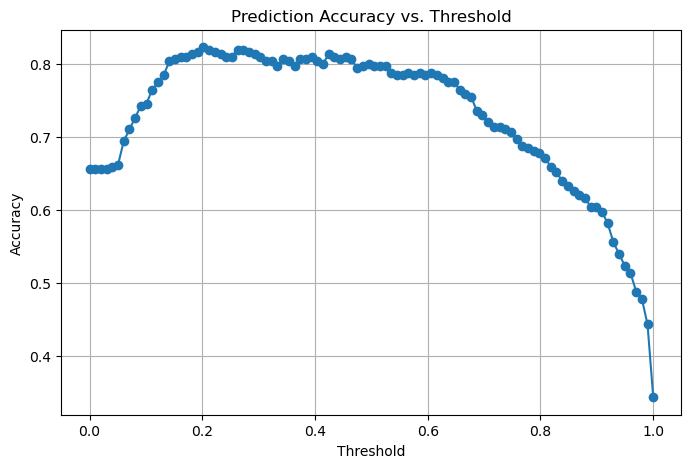

In [27]:
## Threshold with Logistic Regression
# Now see how the accuracy changes with the threshold
from sklearn.metrics import accuracy_score

# Get predicted probabilities for class 1
y_probs = log_reg.predict_proba(X_test)[:, 1]

# Create a range of thresholds to test
thresholds = np.linspace(0, 1, 100)
accuracies = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot accuracy vs. threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy vs. Threshold')
plt.grid(True)
plt.show()

In [28]:
## Select all features (text + outlet) and the target variable
features = ['sentence', 'num_sent', 'n_biased_words', 'sentence_word_count', 'avg_word_length', 'unique_word_count',
            'outlet', 'topic', 'type', 'factual_reporting', 'reliability_label']
target = 'Label_bias_binary'

X = df[features]
y = df[target]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify keeps class balance!
)

In [29]:
# List categorical & numerical variables
categ_cols = ['outlet', 'topic', 'type', 'factual_reporting']
num_cols = ['num_sent', 'n_biased_words', 'sentence_word_count', 'avg_word_length', 'unique_word_count', 'reliability_label']

# Text transformer with the tokenize function
text_transformer = TfidfVectorizer(
    tokenizer=tokenize, preprocessor=None, token_pattern=None,
    ngram_range=(1,2), max_features=1000
)
cat_transformer = OneHotEncoder()
num_transformer = StandardScaler()

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'sentence'),
        ('cat', cat_transformer, categ_cols),
        ('num', num_transformer, num_cols)
    ]
)

In [30]:
## Define each model's pipeline
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),
    'SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LinearSVC(class_weight='balanced'))
    ]),
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_neighbors=5))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(eval_metric='logloss', random_state=42,
                                     scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])))
    ]),
}

In [31]:
## Cross-validation using accuracy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    acc_results[name] = scores
    print(f"{name} - Accuracy scores: {scores}")
    print(f"{name} - Mean: {np.mean(scores):.3f}, Std: {np.std(scores):.3f}")

Logistic Regression - Accuracy scores: [0.81854839 0.7983871  0.79435484 0.81048387 0.81048387]
Logistic Regression - Mean: 0.806, Std: 0.009
SVM - Accuracy scores: [0.79435484 0.79032258 0.80645161 0.78629032 0.80645161]
SVM - Mean: 0.797, Std: 0.008
KNN - Accuracy scores: [0.77016129 0.74596774 0.75       0.80241935 0.78225806]
KNN - Mean: 0.770, Std: 0.021
Random Forest - Accuracy scores: [0.80241935 0.80645161 0.81451613 0.7983871  0.79435484]
Random Forest - Mean: 0.803, Std: 0.007
XGBoost - Accuracy scores: [0.81451613 0.80645161 0.8266129  0.7983871  0.81048387]
XGBoost - Mean: 0.811, Std: 0.009


/var/folders/rm/6mtj7p8d2fz8qhs9gm648gm80000gn/T/ipykernel_42601/674002143.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(acc_results.values(), labels=acc_results.keys())


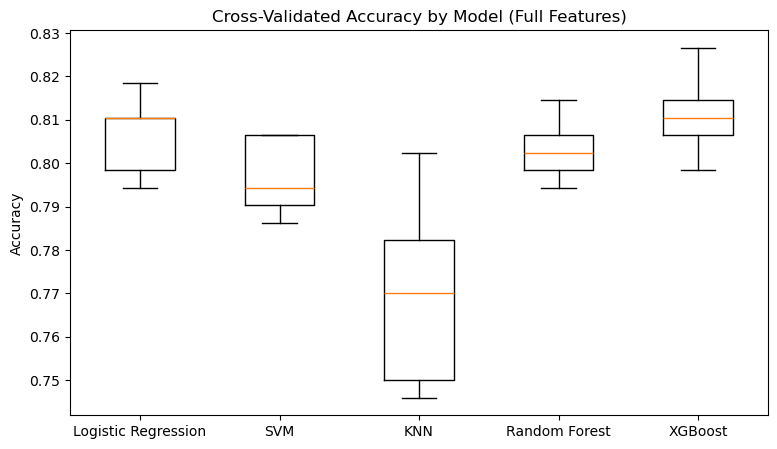

In [32]:
plt.figure(figsize=(9,5))
plt.boxplot(acc_results.values(), labels=acc_results.keys())
plt.ylabel('Accuracy')
plt.title('Cross-Validated Accuracy by Model (Full Features)')
plt.show()

In [33]:
## Cross-validation using F1 scores
from sklearn.metrics import make_scorer, f1_score
f1_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    f1_results[name] = scores
    print(f"{name} - {'f1'} scores: {scores}")
    print(f"{name} - Mean: {np.mean(scores):.3f}, Std: {np.std(scores):.3f}")


Logistic Regression - f1 scores: [0.85804416 0.83870968 0.8411215  0.84280936 0.84984026]
Logistic Regression - Mean: 0.846, Std: 0.007
SVM - f1 scores: [0.84307692 0.83950617 0.85628743 0.83067093 0.85365854]
SVM - Mean: 0.845, Std: 0.009
KNN - f1 scores: [0.83381924 0.80966767 0.81547619 0.85106383 0.83435583]
KNN - Mean: 0.829, Std: 0.015
Random Forest - f1 scores: [0.85459941 0.85798817 0.86470588 0.84939759 0.8440367 ]
Random Forest - Mean: 0.854, Std: 0.007
XGBoost - f1 scores: [0.85889571 0.85185185 0.87240356 0.8427673  0.85626911]
XGBoost - Mean: 0.856, Std: 0.010


/var/folders/rm/6mtj7p8d2fz8qhs9gm648gm80000gn/T/ipykernel_42601/1188449639.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(f1_results.values(), labels=f1_results.keys())


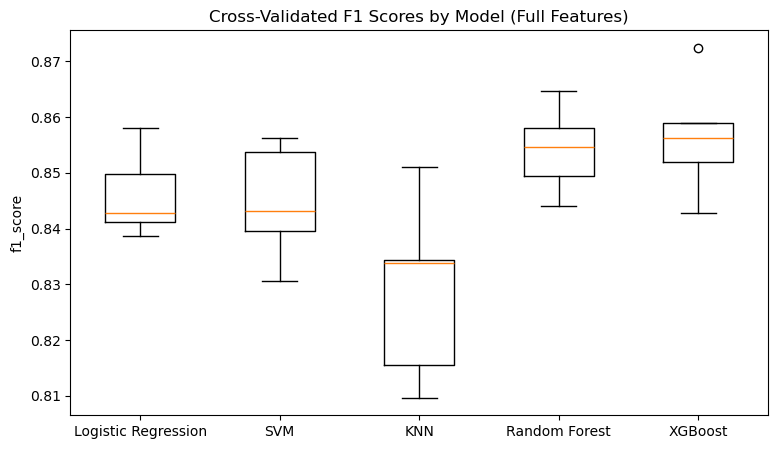

In [34]:
# Visualize results
plt.figure(figsize=(9,5))
plt.boxplot(f1_results.values(), labels=f1_results.keys())
plt.title(f'Cross-Validated F1 Scores by Model (Full Features)')
plt.ylabel('f1_score')
plt.show()

In [35]:
## XG Boost as the best-fitting model

xgb = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(eval_metric='logloss', random_state=42,
                                     scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])))
    ])

xgb.fit(X_train, y_train)


# Hyperparamter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 150, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

gs = GridSearchCV(xgb, param_grid, scoring='f1', cv=3)
gs.fit(X_train, y_train)

print("Best parameters:", gs.best_params_)
print("Best cross-validated F1 score:", gs.best_score_)

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
Best cross-validated F1 score: 0.8592509310659827


In [36]:
# Recreate the model pipeline with best parameters
final_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        learning_rate=0.1,
        max_depth=3,
        n_estimators=100,
        subsample=1.0,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])
    ))
])

# Fit on the full training set
final_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=1000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  token_pattern=None,
                                                                  tokenizer=<function tokenize at 0x152b8e020>),
                                                  'sentence'),
                                                 ('cat', OneHotEncoder(),
                                                  ['outlet', 'topic', 'type',
                                                   'factual_reporting']),
                                                 ('num', StandardScaler(),
                                                  ['num_sent', 'n_biased_words',
                                                   'sentence_word_count',
                                                   'avg_wo...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

              precision    recall  f1-score   support

           0       0.68      0.77      0.72       107
           1       0.87      0.81      0.84       204

    accuracy                           0.80       311
   macro avg       0.78      0.79      0.78       311
weighted avg       0.81      0.80      0.80       311



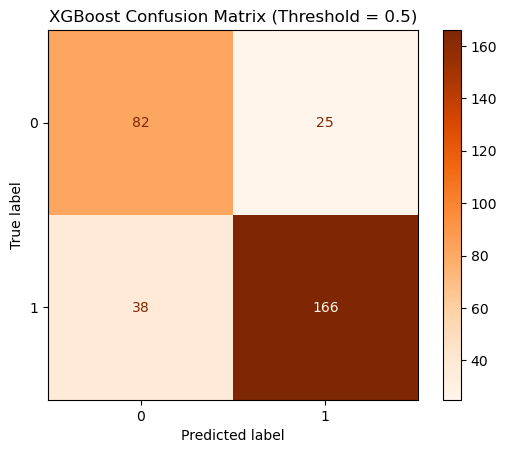

In [37]:
# Predict and evaluate on the test set
y_pred = final_xgb.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_xgb.named_steps['classifier'].classes_)
disp.plot(cmap='Oranges')
plt.title('XGBoost Confusion Matrix (Threshold = 0.5)')
plt.show()

              precision    recall  f1-score   support

           0       0.73      0.65      0.69       107
           1       0.83      0.87      0.85       204

    accuracy                           0.80       311
   macro avg       0.78      0.76      0.77       311
weighted avg       0.79      0.80      0.79       311



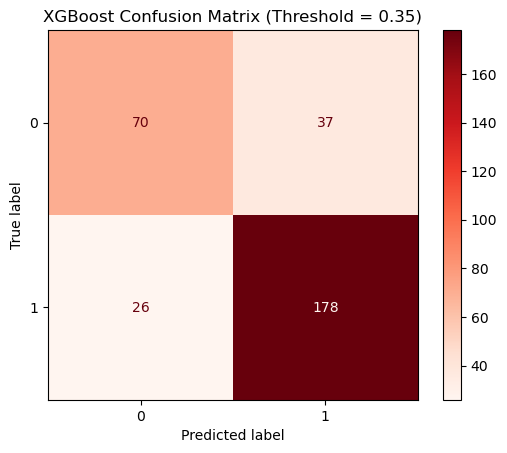

In [38]:
# Lower the threshold to catch more biased sentences
threshold = 0.35

# Get predicted probabilities for the positive class
y_probs = xgb.predict_proba(X_test)[:, 1]
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate at custom threshold
print(classification_report(y_test, y_pred_custom))

# Plot confusion matrix for custom threshold
cm_custom = confusion_matrix(y_test, y_pred_custom)
disp_custom = ConfusionMatrixDisplay(confusion_matrix=cm_custom, display_labels=xgb.named_steps['classifier'].classes_)
disp_custom.plot(cmap='Reds')
plt.title(f'XGBoost Confusion Matrix (Threshold = {threshold})')
plt.show()


In [40]:
## Feature importance
# Get all features
text_features = preprocessor.named_transformers_['text'].get_feature_names_out()
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categ_cols)
num_features = num_cols
all_features = np.concatenate([text_features, cat_features, num_features])

# Extract importances from XGBoost
importances = final_xgb.named_steps['classifier'].feature_importances_

# Create a dataframe and sort
fi_df = pd.DataFrame({'feature': all_features, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False)

print("\nTop 20 most important features:\n")
print(fi_df.head(20))


Top 20 most important features:

                                          feature  importance
1028                               n_biased_words    0.138528
1022                                  type_center    0.039189
1002                            outlet_federalist    0.034044
961                                          week    0.032406
1000                              outlet_alternet    0.026073
1015  topic_international-politics-and-world-news    0.023171
906                                         trump    0.021949
1017                                  topic_sport    0.018343
760                                          said    0.017036
51                                        america    0.016753
320                                         first    0.015898
664                              president donald    0.015628
924                                 united states    0.014848
749                                        rights    0.014511
341                                 

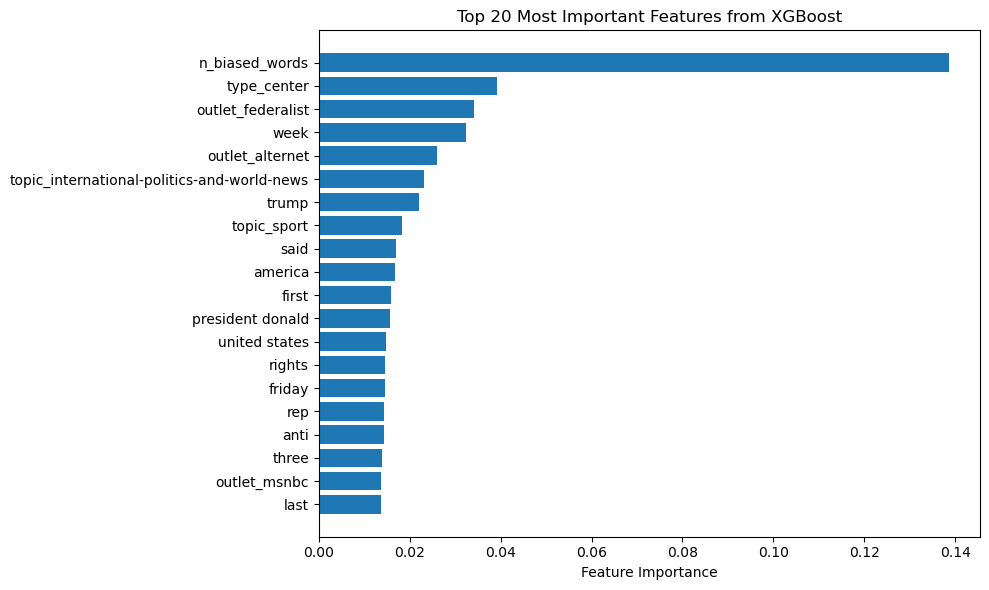

In [41]:
# Plot top feature importance
top_n = 20
plt.figure(figsize=(10,6))
plt.barh(fi_df['feature'].head(top_n)[::-1], fi_df['importance'].head(top_n)[::-1])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features from XGBoost')
plt.tight_layout()
plt.show()